In [20]:
%pylab inline
import pandas as pd
from torch.autograd import Variable
from torch import nn
import torch

Populating the interactive namespace from numpy and matplotlib


In [21]:
DATA_DIR = "/home/astyonax/Projects/PostDoc/Paris/Traffic/data/"

In [22]:
#simplified data
data = pd.read_hdf(DATA_DIR+'/aggregates.hdf')
data['timestep']=data.hour+data.month*100
data = data.sort_values(by='timestep')

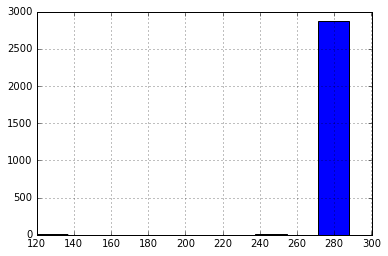

In [23]:
data.groupby('id_arc_trafic').agg('count')['timestep'].hist()

Not every counter worked all the time as the others. We remove them from the dataset

In [24]:
how_long = data.groupby('id_arc_trafic',as_index=False).agg('count')[['id_arc_trafic','timestep']]
how_long.columns=['id_arc_trafic','how_long']
which_id_arc_trafic = how_long[how_long.how_long==288].id_arc_trafic.values

In [25]:
def filter_id_arc_trafic(j):
    if j in which_id_arc_trafic:
        return 1
    return 0
data['filtered'] = data.id_arc_trafic.apply(filter_id_arc_trafic)

In [26]:
filtered = data[data.filtered==1]

In [27]:
time_series = [j[1]['AVG(debit)'].values for j in filtered.groupby('timestep')]

In [54]:
l = [len(ts) for ts in time_series]
time_series = np.asarray(time_series)
print time_series.shape
np.save(open('data/time_series_traffic_paris.npy','w'),time_series)

(288, 2871)


# Machine learning begins here
time series is a 288 steps by 2871 features (or coins) array.

This particular data is coming from a simplified array of paris traffic.. just to play w/ something I know

In [29]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
Q = scaler.fit_transform(time_series)

In [30]:
W = 6

def batch_gen(data,batch_size=32,shuffle=True,window_size=W):
    
    #~ win creat
    ws = window_size
    windows = [[data[i+n] for i in range(0, len(data)-1-ws, ws)] for n in range(ws)]
    windows = np.asarray(windows).transpose(1,0,-1)
    #~
    if shuffle:
        index = np.random.permutation(windows.shape[0])
        windows = windows[index,:]
    #~
    windows = Variable(torch.from_numpy(windows.astype(np.float32)))
    for idx in range(0,windows.size(0),batch_size):
        outin = windows[idx:idx+batch_size]
        x = outin[:,:-1]
        y = outin[:,-1]
        yield x,y

In [31]:
x,y = next(batch_gen(Q))
x.size(),y.size()

(torch.Size([32, 5, 2871]), torch.Size([32, 2871]))

In [78]:
class new_RNN(nn.Module):
    def __init__(self, inout_dim, hidden_dim =256, lr = 0.001):
        super(new_RNN, self).__init__()
        
        self._inout_dim = inout_dim
        self._hidden_dim = hidden_dim
        self.lin_in = nn.Linear(inout_dim,hidden_dim)
        self.cell = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        self.lin_out = nn.Linear(hidden_dim,inout_dim)
        
        # functions
        self.__lr = lr
        self.loss = nn.MSELoss()
        self.optimizer = self.__init_optimizer()
#         self.activation = torch.nn.Activation('linear')
        
    def forward(self, c):
        hidden = (Variable(torch.randn(1,1,self._hidden_dim)),
                  Variable(torch.randn(1,1,self._hidden_dim)))
        
        output = self.lin_in(c)
        output,hidden = self.cell(output,hidden)
        output = self.lin_out(output)
        output = output.max(dim=1)[0]
#         output = self.activation(output)
        return output
        
    @property
    def lr(self):
        return self.__lr
    
    @lr.setter
    def lr(self,new_lr):
        self.__lr = new_lr
        self.optimizer = self.__init_optimizer()
    
    def __init_optimizer(self):
        return torch.optim.SGD(self.parameters(),lr = self.__lr,momentum=.9,weight_decay=1e-3,nesterov=True)

In [79]:
print x.size()

torch.Size([32, 5, 2871])


In [83]:

try:
    raise IOError
    rnn = torch.load('rnn.pth')
    print('loaded rnn from file')
    
except IOError:
    rnn = new_RNN(x.size(-1),hidden_dim=2**8)

In [84]:
rnn(x).size()

torch.Size([32, 2871])

In [94]:
np2y= lambda x:Variable(torch.from_numpy(x.astype(np.float32))).unsqueeze(0)
def validate(Q,model,W):
    real = []
    pred = []
    model.eval()
    for i in xrange(W,Q.shape[0]-1):
        t0 = Q[i-W:i]
        t1 = Q[i]
        t1_pred = model(np2y(t0)).squeeze().data.numpy()
        
        real.append(scaler.inverse_transform(t1.reshape(1,-1)).mean())
        pred.append(scaler.inverse_transform(t1_pred.reshape(1,-1)).mean())
    
    real = np.asarray(real)
    pred = np.asarray(pred)
    
    MSEscore = np.sum((real-pred)**2)**.5
    
    return MSEscore,{'real':real,'pred':pred}

def new_train_model(batches_gen,data,model,epochs=1000,train=True,ev=1,window_size=W):
    if train:
        model.train()
    else:
        model.eval()
        
    for epoch in range(epochs):
        batches = batches_gen(data,window_size=window_size)
        running_loss = 0.0
    
        for x,y in batches:
            out = model(x)
            loss = model.loss(out,y)
            model.zero_grad()
            loss.backward()
            model.optimizer.step()
            
            running_loss += loss.data[0]
            
        if epoch%ev==0 or epoch == epochs-1:
            
            epoch_loss = running_loss
            print('{0:d} {1:e} {2:e}'.format(epoch,epoch_loss,validate(Q,model,window_size)))            

In [ ]:
rnn.lr=0.1
new_train_model(batch_gen,Q,rnn,epochs=3000,ev=500,window_size=W)

In [ ]:
# print (y.size(),
#        y.unsqueeze(1).size())

In [32]:
torch.save(rnn,'rnn.pth')
!ls rnn.pth -lthr

-rw-r--r-- 1 astyonax astyonax 39M Jan  2 13:13 rnn.pth


## Plot Validation

In [97]:
real = []
pred = []
rnn.eval()
time = range(W,Q.shape[0]-1)
for i in time:
    t0 = Q[i-W:i]
    t1 = Q[i]
    t1_pred = rnn(np2y(t0)).squeeze().data.numpy()
        
#     print t1.mean(),t1_pred.mean()
    real.append(scaler.inverse_transform(t1.reshape(1,-1)).mean())
    pred.append(scaler.inverse_transform(t1_pred.reshape(1,-1)).mean())

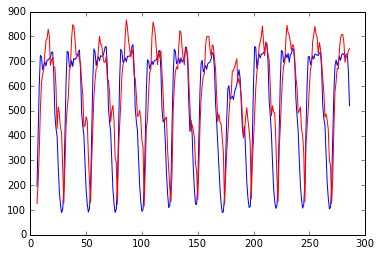

In [98]:
plt.plot(time,real)
plt.plot(time,pred,'r')

In [99]:
validate(Q,rnn,W)[0]

2352.6941820241918

In [100]:
rnn = torch.load('rnn.pth')

In [89]:
real = []
pred = []
rnn.eval()
w= 6
time = range(w,Q.shape[0]-1)
for i in time:
    t0 = Q[i-w:i]
    t1 = Q[i]
    t1_pred = rnn(np2y(t0)).squeeze().data.numpy()
        
#     print t1.mean(),t1_pred.mean()
    real.append(scaler.inverse_transform(t1.reshape(1,-1)).squeeze()[100])
    pred.append(scaler.inverse_transform(t1_pred.reshape(1,-1)).squeeze()[100])

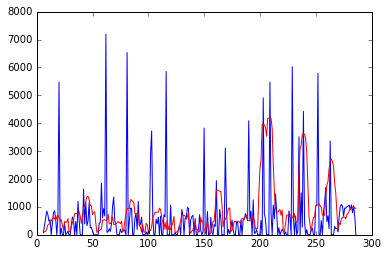

In [90]:
plt.plot(time,real)
plt.plot(time,pred,'r')

Above: one prediction on a single counter after 2500 epochs 